# Speeches project
Maciej Lorens

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_theme(style='darkgrid')

# Text mining modules from Sklearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Modules from nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

lemmatizer = WordNetLemmatizer()

In [2]:
# Function for cleaning the text
def preprocess_text(text):

    # Removing special characters, punctuation, whitespaces and numbers
    text_clean = re.sub("[^a-zA-Z0-9 \n\.]", "", text)
    text_clean = re.sub(" +", " ", text_clean)
    text_clean = re.sub(r"[^\w\s]","", text_clean)
    text_clean = re.sub("\d", "", text_clean)

    # Changing the text into lowercase
    text_clean = text_clean.lower()

    # Applying tokenization to the text
    word_tokens = word_tokenize(text_clean)

    # Removing english stopwords
    stop_words = set(stopwords.words("english")) 
    word_tokens = [w for w in word_tokens if w not in stop_words]

    # Applying lemmatization to the tokens
    word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]

    text_clean = " ".join(word_tokens)

    return text_clean


# Function to plot SSE for a chosen range of k number of clusters
def get_clusters_number(data, max_k):

    sse = []
    k_range = range(2, max_k+1)

    for k in k_range:
        kfit = KMeans(n_clusters=k, n_init='auto', random_state=42)
        sse.append(kfit.fit(data).inertia_)

    plt.plot(k_range, sse, marker='o')
    plt.title("SSE for k number of clusters")
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.xticks(k_range)
    plt.show()


# Function to plot the clusters
def plot_clusters(tfidf_vectors, clusters, num_k):

    # Computing the pca vectors for visualizing the clusters
    pca = PCA(n_components=2)
    pca_vectors = pca.fit_transform(tfidf_vectors.toarray())

    # Plotting the clusters
    plt.scatter(pca_vectors[:, 0], pca_vectors[:, 1], c=clusters, cmap='viridis')
    plt.title(f"Clustering results for k={num_k}")
    plt.xlabel(f"Principal Component 1 ({round(pca.explained_variance_[0]*100, 2)}%)")
    plt.ylabel(f"Principal Component 2 ({round(pca.explained_variance_[1]*100, 2)}%)")
    plt.show()


# Function to get the top n keywords for each cluster
def get_top_keywords(data, clusters, labels, n_terms):
    
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i, r in df.iterrows():
        print(f'\nCluster {i}')
        # Sorting values in decreasing order and printing the first n terms
        print(', '.join([labels[t] for t in np.argsort(r)[::-1][:n_terms]]))

In [3]:
speeches_df = pd.read_csv("Erdogan_translated_speeches.csv")

In [4]:
speeches_df.head()

,Translated_title,Date,Translated_text,Event_date,Detail,When
0,Their Speech at the Inauguration Ceremony,2023-06-03,"\n\nDear Nation, Dear Heads of State and Gover...",2023-05-28,Recep Tayyip Erdoğan won the election between ...,after
1,Their Speech at the Social Complex After the E...,2023-05-28,\n\nWe love Turkey very much. Isn't this natio...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,after
2,"Strong Industry, Strong Türkiye Speech at the ...",2023-05-25,"\n\nDear Industrialists,\nDear Brothers and Si...",2023-05-28,Recep Tayyip Erdoğan won the election between ...,before
3,Their Speech at the Keçiören NGO Representativ...,2023-05-24,"\n\nDear Ankara residents,\nDear Beautiful Peo...",2023-05-28,Recep Tayyip Erdoğan won the election between ...,before
4,Their Speech at the Great Rumelia Meeting,2023-05-22,"\n\nOur Dear Youth,\nDear Ladies and Sisters,\...",2023-05-28,Recep Tayyip Erdoğan won the election between ...,before


In [5]:
# Checking for NAs, there is none
speeches_df.isna().sum()

Translated_title    0
Date                0
Translated_text     0
Event_date          0
Detail              0
When                0
dtype: int64

In [6]:
# Applying the preprocessing function to a copy of the data frame
text_df_clean = speeches_df.copy()

text_df_clean["Translated_text"] = text_df_clean.Translated_text.map(preprocess_text)

text_df_clean.head()

,Translated_title,Date,Translated_text,Event_date,Detail,When
0,Their Speech at the Inauguration Ceremony,2023-06-03,dear nation dear head state government dear pa...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,after
1,Their Speech at the Social Complex After the E...,2023-05-28,love turkey much isnt nation loved love qandil...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,after
2,"Strong Industry, Strong Türkiye Speech at the ...",2023-05-25,dear industrialist dear brother sister greet h...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,before
3,Their Speech at the Keçiören NGO Representativ...,2023-05-24,dear ankara resident dear beautiful people kei...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,before
4,Their Speech at the Great Rumelia Meeting,2023-05-22,dear youth dear lady sister dear citizen greet...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,before


## Text clustering

In [10]:
# Creating the tf-idf vectors
# It may be more interesting to include bigrams
# I remove the terms that appear in less than 5% of all documents
tfidf_text_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.05)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(text_df_clean.Translated_text)

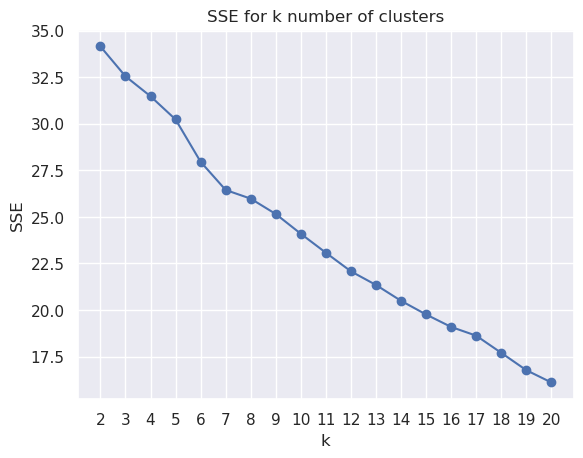

In [22]:
# Based on the elbow method, seems like 7 is an appropriate number of clusters
get_clusters_number(tfidf_text_vectors, 20)

In [11]:
# Applying K-means
text_k = 7
kfit = KMeans(n_clusters=text_k, n_init='auto', random_state=42)
clusters = kfit.fit_predict(tfidf_text_vectors)

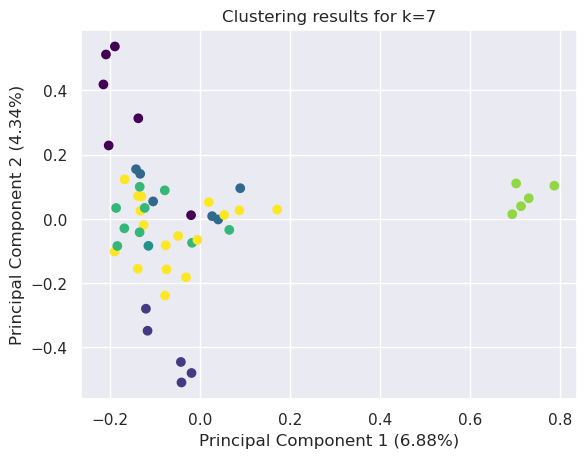

In [24]:
# Plotting the clusters
# It is worth noting that the plot may not be ideal, since the explained variance is not high
plot_clusters(tfidf_text_vectors, clusters, text_k)

In [25]:
# Printing top 15 keywords
get_top_keywords(tfidf_text_vectors, clusters, tfidf_text_vectorizer.get_feature_names_out(), 15)


Cluster 0
istanbul, brother, conquest, binali, say, know, chp, nation, candidate, people, one, yldrm, mayor, metropolitan, binali yldrm

Cluster 1
nation, coup, july, coup attempt, attempt, country, one, turkey, state, armed, terrorist, force, organization, democracy, tank

Cluster 2
nation, country, konya, people, teknofest, brother, turkey, one, say, mr kemal, chp, kemal, young, space, year

Cluster 3
system, country, presidential system, nation, say, yes, presidential, executive, one, military service, governed, management, new system, constitutional amendment, amendment

Cluster 4
nation, brother, country, say, people, turkey, know, headman, mosque, one, siva, said, come, van, rize

Cluster 5
earthquake, aid, disaster, thousand, rescue, search rescue, earthquake zone, search, zone, province, region, team, destruction, citizen, country

Cluster 6
nation, country, turkey, election, party, one, people, like, would, brother, year, ak party, every, ak, dear


## Topic Modeling

In [13]:
# Creating new dataframe with preprocessed text for lda
lda_df = text_df_clean.copy()
lda_df["Translated_text"] = lda_df.Translated_text.map(preprocess_text)
lda_df = lda_df.loc[lda_df.Translated_text != ""]

### With coherence score

Coherence score is a measure used for determining the interpretability of LDA topics to humans. Naturally, it can be used for optimizing the number of topics.

In [14]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Positive corpora
speeches = [x.split() for x in lda_df["Translated_text"]]
dictionary = Dictionary(speeches)
corpus = [dictionary.doc2bow(speech) for speech in speeches]

In [45]:
import tqdm
from gensim.models import CoherenceModel
import numpy as np
import warnings

# Function for computing the coherence score
def compute_coherence_values(corpus, sent_tweets, sentim_id2word, k, a, b):
    lda_model = LdaModel(corpus=corpus,
                         id2word=sentim_id2word,
                         num_topics=k, 
                         random_state=42,
                         chunksize=len(corpus),
                         passes=10,
                         alpha=a,
                         eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=sent_tweets, dictionary=sentim_id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

# Function for computing the coherence score for different hyperparameter combinations
def topic_num_search(sent_corpus, sent_tweets, sentim_dict):
    grid = {}
    grid['Validation_Set'] = {} 

    min_topics = 2
    max_topics = 10
    step_size = 2
    topics_range = range(min_topics, max_topics, step_size)

    warnings.filterwarnings("ignore", category=DeprecationWarning) 

    num_of_tweets = len(sent_corpus)
    corpus_sets = [sent_corpus]
    corpus_title = ['100% Corpus']

    alpha=['symmetric', 'asymmetric']
    beta=['symmetric']

    model_results = {'Validation_Set': [],
                    'Topics': [],
                    'Alpha': [],
                    'Beta': [],
                    'Coherence': []
                    }

    if 1 == 1:
        pbar = tqdm.tqdm(total=len(corpus_sets)*len(topics_range)*len(alpha)*len(beta))
        
        for i in range(len(corpus_sets)):
            for k in topics_range:
                for a in alpha:
                    for b in beta:
                        print(i, k, a, b)
                        
                        cv = compute_coherence_values(corpus=corpus_sets[i], sent_tweets=sent_tweets, sentim_id2word=sentim_dict,
                                                      k=k, a=a, b=b)
                        model_results['Validation_Set'].append(corpus_title[i])
                        model_results['Topics'].append(k)
                        model_results['Alpha'].append(a)
                        model_results['Beta'].append(b)
                        model_results['Coherence'].append(cv)
                        print({k: v[-1] for k, v in model_results.items()})

                        pbar.update(1)
        pbar.close()
        model_results=pd.DataFrame(model_results)
    
    return model_results

In [46]:
model_results = topic_num_search(corpus, speeches, dictionary)

  0%|          | 0/8 [00:00<?, ?it/s]

0 2 symmetric symmetric


 12%|█▎        | 1/8 [00:04<00:31,  4.51s/it]

{'Validation_Set': '100% Corpus', 'Topics': 2, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.3032912817136787}
0 2 asymmetric symmetric


 25%|██▌       | 2/8 [00:09<00:28,  4.73s/it]

{'Validation_Set': '100% Corpus', 'Topics': 2, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.3032912817136787}
0 4 symmetric symmetric


 38%|███▊      | 3/8 [00:13<00:22,  4.56s/it]

{'Validation_Set': '100% Corpus', 'Topics': 4, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.33940776565192393}
0 4 asymmetric symmetric


 50%|█████     | 4/8 [00:18<00:18,  4.61s/it]

{'Validation_Set': '100% Corpus', 'Topics': 4, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.33120057881304676}
0 6 symmetric symmetric


 62%|██████▎   | 5/8 [00:24<00:15,  5.08s/it]

{'Validation_Set': '100% Corpus', 'Topics': 6, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.32526562807468296}
0 6 asymmetric symmetric


 75%|███████▌  | 6/8 [00:30<00:10,  5.30s/it]

{'Validation_Set': '100% Corpus', 'Topics': 6, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.3301259608103639}
0 8 symmetric symmetric


 88%|████████▊ | 7/8 [00:36<00:05,  5.52s/it]

{'Validation_Set': '100% Corpus', 'Topics': 8, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.32265082390344646}
0 8 asymmetric symmetric


100%|██████████| 8/8 [00:42<00:00,  5.27s/it]

{'Validation_Set': '100% Corpus', 'Topics': 8, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.3272374722052589}


In [47]:
model_results.sort_values('Coherence', ascending = False).head()

,Validation_Set,Topics,Alpha,Beta,Coherence
2,100% Corpus,4,symmetric,symmetric,0.339408
3,100% Corpus,4,asymmetric,symmetric,0.331201
5,100% Corpus,6,asymmetric,symmetric,0.330126
7,100% Corpus,8,asymmetric,symmetric,0.327237
4,100% Corpus,6,symmetric,symmetric,0.325266


In [50]:
# Creating LDA models with the hyperparameters chosen according to the highest coherence score
passes=10

# LDA model for positive tweets
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=len(corpus),
    alpha='symmetric',
    eta='symmetric',
    random_state=42,
    num_topics=4,
    passes=passes,
    per_word_topics=True
)

In [51]:
# Function for displaying top n words from each topic
def display_topics(lda_model, num_topics, no_top_words):
    topic_dict = {}
    for idx in range(num_topics):
        topic_dict[f"Topic {idx} words"]= [x[0] for x in lda_model.show_topic(idx, no_top_words)]

        topic_dict[f"Topic {idx} weights"]= [round(x[1], 4) for x in lda_model.show_topic(idx, no_top_words)]
    return pd.DataFrame(topic_dict)

In [52]:
display_topics(lda_model, 4, 10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,nation,0.0143,earthquake,0.0173,nation,0.0110,nation,0.0149
1,country,0.0115,thousand,0.0130,brother,0.0089,country,0.0082
2,u,0.0095,country,0.0088,istanbul,0.0083,brother,0.0081
3,people,0.0092,nation,0.0064,country,0.0082,one,0.0079
4,turkey,0.0091,work,0.0064,say,0.0081,turkey,0.0066
5,brother,0.0090,citizen,0.0063,know,0.0064,like,0.0063
6,one,0.0075,disaster,0.0061,people,0.0060,say,0.0061
7,say,0.0067,region,0.0058,turkey,0.0059,coup,0.0060
8,party,0.0056,aid,0.0051,one,0.0057,u,0.0058
9,election,0.0054,province,0.0050,u,0.0053,god,0.0058


## Sentiment Analysis

In [7]:
par_list = [par for speech in speeches_df["Translated_text"].map(lambda x: x.split("\n")) for par in speech if par != ""]

In [8]:
par_df = pd.DataFrame(par_list, columns=["Paragraph"])

In [9]:
par_df["Sentiment"] = par_df.Paragraph.map(analyser.polarity_scores)
par_df["Sentiment"] = par_df["Sentiment"].map(lambda x: x["compound"])

In [10]:
# Applying typical threshold values from the literature: https://github.com/cjhutto/vaderSentiment
par_df["Sentiment"] = par_df["Sentiment"].map(lambda x: "positive" if x>=0.05 else ("neutral" if x>-0.05 else "negative"))

In [11]:
par_df.groupby("Sentiment").count()

,Paragraph
Sentiment,
negative,845
neutral,582
positive,2247


In [15]:
par_df.Paragraph = par_df.Paragraph.map(lambda x: preprocess_text(x))

In [17]:
par_df.head()

,Paragraph,Sentiment
0,dear nation dear head state government,positive
1,dear parliament speaker,positive
2,vice president,neutral
3,dear country representative dear friend home a...,positive
4,lady gentleman,neutral


In [16]:
pos_df = par_df.loc[par_df.Sentiment == "positive"].reset_index(drop=True)
neg_df = par_df.loc[par_df.Sentiment == "negative"].reset_index(drop=True)